<a href="https://colab.research.google.com/github/GabyDs/EjerciciosInteligenciaComputacional/blob/main/Lab3Ej3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introducción

 [YAMNet](https://tfhub.dev/google/yamnet/1) ("*Yet another Audio Mobilenet Network*") es un modelo preentrenado que predice 521 eventos de audio basados en el [AudioSet corpus](https://research.google.com/audioset/).

Este modelo está disponible en TensorFlow Hub, incluidas las versiones TFLite y TF.js, para ejecutar el modelo en dispositivos móviles y en la web. El código se puede encontrar en su [repositorio](https://github.com/tensorflow/models/tree/master/research/audioset/yamnet).

El modelo tiene 3 salidas:

*   Puntuaciones de clase que usaría para la inferencia
*   *Embeddings*, que son la parte importante para el aprendizaje de transferencia (***esto puede usarse para entrenar un nuevo clasificador***)
*   Espectrograma *Log Mel* para proporcionar una visualización de la señal de entrada


El modelo toma una forma de onda representada como muestras de **16 kHz** en el rango `[-1,0; 1,0]`, la enmarca en ventanas de **0,96 segundos** y saltos de **0,48 segundos**, y luego ejecuta el núcleo del modelo para extraer las incrustaciones en un lote de estos *frames*.

<img src="https://1.bp.blogspot.com/-CLyq7ilQIow/YDawZXp_NiI/AAAAAAAAEEg/vVa58jb24Fkw-LZPsezB_qMdnvndOYuzwCLcBGAsYHQ/s0/yamnet_animation%2B%25282%2529.gif" align="left" style="float" width="800">
<font color="#3279ca">

Una salida típica del modelo, puede representarse cómo:

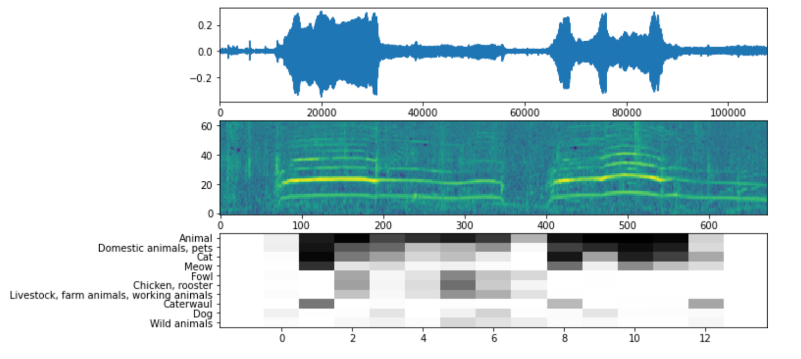

## Ejemplo de Uso

In [16]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
import csv

import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile
import scipy

In [2]:
# Load the model.
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

### Funciones auxiliares

In [6]:
# Find the name of the class with the top score when mean-aggregated across frames.
def class_names_from_csv(class_map_csv_text):
  """Returns list of class names corresponding to score vector."""
  class_names = []
  with tf.io.gfile.GFile(class_map_csv_text) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      class_names.append(row['display_name'])

  return class_names

class_map_path = yamnet_model.class_map_path().numpy()

# Vector con los nombres de las etiqutas/clases de salida del modelo
class_names = class_names_from_csv(class_map_path)

In [7]:
# Función para verificar y convertir un audio cargado en el sample_rate adecuado (16K); de lo contrario, afectaría los resultados del modelo.
def ensure_sample_rate(original_sample_rate, waveform,
                       desired_sample_rate=16000):
  """Resample waveform if required."""
  if original_sample_rate != desired_sample_rate:
    desired_length = int(round(float(len(waveform)) /
                               original_sample_rate * desired_sample_rate))
    waveform = scipy.signal.resample(waveform, desired_length)
  try:
    if waveform.shape[1] > 1:
        # Solo un canal, admite MONO
        waveform = wav_data[:,0]
  except:
    # Es MONO entonces, no tiene 2da dimensión
    pass
  return desired_sample_rate, waveform

### Preprocesamiento

In [8]:
!wget -c --no-check-certificate "https://drive.google.com/uc?export=download&id=1lO972IgfEKw6FZQ32WBs_l6BLZg5Dlz2&confirm=t" -O firmas_varias_ejemplo.zip
!unzip -qq firmas_varias_ejemplo.zip

--2023-05-23 17:08:10--  https://drive.google.com/uc?export=download&id=1lO972IgfEKw6FZQ32WBs_l6BLZg5Dlz2&confirm=t
Resolving drive.google.com (drive.google.com)... 173.194.216.113, 173.194.216.101, 173.194.216.139, ...
Connecting to drive.google.com (drive.google.com)|173.194.216.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5lnmo02i05vkm7iasvil0b7l9ln9g5sk/1684861650000/12225850433951268217/*/1lO972IgfEKw6FZQ32WBs_l6BLZg5Dlz2?e=download&uuid=13c2fdf1-da8e-40d1-8b6a-d61ab9f3f39f [following]
--2023-05-23 17:08:11--  https://doc-0s-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5lnmo02i05vkm7iasvil0b7l9ln9g5sk/1684861650000/12225850433951268217/*/1lO972IgfEKw6FZQ32WBs_l6BLZg5Dlz2?e=download&uuid=13c2fdf1-da8e-40d1-8b6a-d61ab9f3f39f
Resolving doc-0s-9c-docs.googleusercontent.com (doc-0s-9c-docs.googleusercontent.com)... 108.177

Probar con cualquier audio, se brindan algunos ejemplos.
De estos, únicamente para '*rana_MONO*' el modelo identifica algo.
El resto es "muy específico".

In [ ]:
wav_file_name = 'urutau.wav'
sample_rate, wav_data = wavfile.read(wav_file_name, 'rb')
sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

# Información básica del archivo.
duration = len(wav_data)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(wav_data)}')

# Para reproducir y verificar
Audio(wav_data, rate=sample_rate)

In [10]:
# Se necesita normalizar la señal de entrada, tal como se indica en la introducción o documentación.
waveform = wav_data / tf.int16.max

In [11]:
waveform.shape

(106983,)

### Inferencia

In [12]:
# Inferencia del modelo
scores, embeddings, spectrogram = yamnet_model(waveform)

In [13]:
embeddings.shape

TensorShape([13, 1024])

### Resultados

In [14]:
# Clase más probable
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
infered_class = class_names[scores_np.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

The main sound is: Silence


Visualización enriquecida: forma de onda, espectrograma y las clases superiores inferidas.

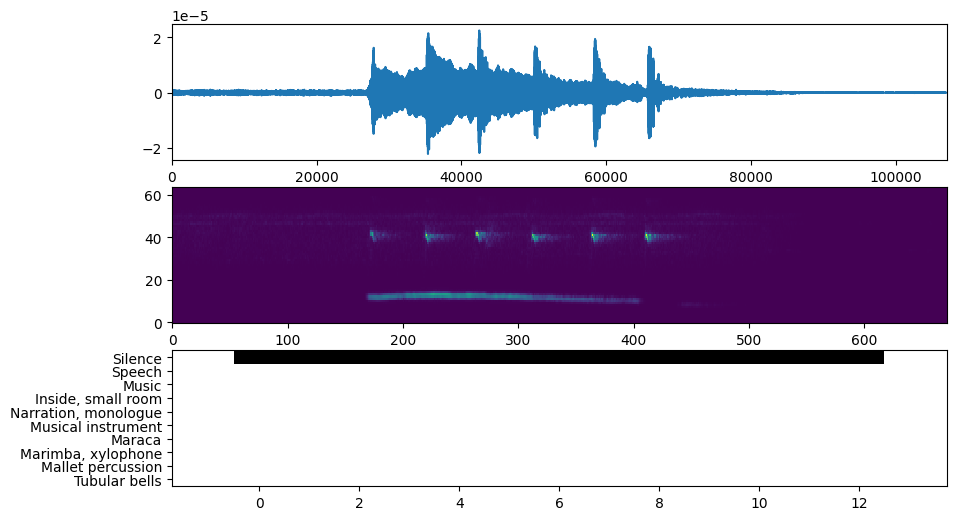

In [15]:
plt.figure(figsize=(10, 6))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_n = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3, 1, 3)
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
# values from the model documentation
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))

## Data Augmentation: for Audio

In [20]:
import random
import librosa      # Esta librería tiene la magia
import numpy as np

In [21]:
def add_white_noise(signal, noise_percentage_factor):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_percentage_factor
    return augmented_signal


def time_stretch(signal, time_stretch_rate):
    """Time stretching implemented with librosa:
    https://librosa.org/doc/main/generated/librosa.effects.pitch_shift.html?highlight=pitch%20shift#librosa.effects.pitch_shift

    time_stretch_rate: > 1, entonces la señal se acelera. < 1 se ralentiza.
    """
    return librosa.effects.time_stretch(signal, rate=time_stretch_rate)


def pitch_scale(signal, sr, num_semitones):
    """Pitch scaling implemented with librosa:
    https://librosa.org/doc/main/generated/librosa.effects.pitch_shift.html?highlight=pitch%20shift#librosa.effects.pitch_shift
    """
    return librosa.effects.pitch_shift(signal, sr=sr, n_steps=sr)


def random_gain(signal, min_factor=0.1, max_factor=0.12):
    gain_rate = random.uniform(min_factor, max_factor)
    augmented_signal = signal * gain_rate
    return augmented_signal


def invert_polarity(signal):
    return signal * -1

In [ ]:
wav_file_name = 'urutau.wav'
sample_rate, wav_data = wavfile.read(wav_file_name, 'rb')
sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

<ipython-input-23-38fca7dd42a9>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, wav_data = wavfile.read(wav_file_name, 'rb')


### Pruebas

In [ ]:
# Original
Audio(wav_data, rate=sample_rate)

In [ ]:
# Ruido Blanco
wav_data_wn = add_white_noise(wav_data, noise_percentage_factor=0.8)
Audio(wav_data_wn, rate=sample_rate)

In [ ]:
# time_stretch: acelerado
wav_data_tsa = time_stretch(wav_data, time_stretch_rate=2)
Audio(wav_data_tsa, rate=sample_rate)

In [ ]:
# time_stretch: lento
wav_data_tsl = time_stretch(wav_data, time_stretch_rate=0.5)
Audio(wav_data_tsl, rate=sample_rate)

In [ ]:
# Cambio de tono
wav_data_ps = pitch_scale(wav_data, sr=1, num_semitones=1.2)
Audio(wav_data_ps, rate=sample_rate)

In [ ]:
# Cambio aleatorio de ganancia
wav_data_rg = random_gain(wav_data,  min_factor=0.1, max_factor=0.8)
Audio(wav_data_rg, rate=sample_rate)

In [ ]:
# Cambio polaridad
wav_data_ip = invert_polarity(wav_data)
Audio(wav_data_ip, rate=sample_rate)

Text(0.5, 1.0, 'Diferencias temporales')

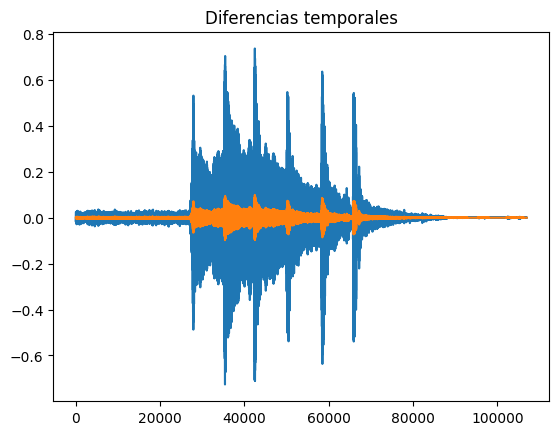

In [ ]:
t = [i for i in range(len(wav_data))]
# Probar cualquiera, siempre y cuando tengan la misma dimensión. time_stretch es el que cambia.
plt.plot(t, wav_data, t, wav_data_rg)
plt.title("Diferencias temporales")

# Preprocesamiento, Modelo y demás...

## Preparacion para el modelo

In [ ]:
"""
Cargar el mapeo de clases
Es importante cargar los nombres de clase que YAMNet puede reconocer.
El archivo de mapeo está presente en yamnet_model.class_map_path() en formato CSV.
"""

class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

In [19]:
# Inferencia (Esta en el ejemplo de uso tambien)

# inferencia

scores, embeddings, spectrogram = yamnet_model(waveform)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Silence
The embeddings shape: (13, 1024)


## Preparacion del dataset

### Armar muestras sinteticas (prueba)

In [22]:
# Para preparar el dataset tenemos que hacer uso de las pocas muestras que tenemos
# y jugar con las funciones de modificacion de tono y demas
# con ello podemos generar muestras sinteticas

audio_path = 'urutau.wav'
audio, sample_rate = librosa.load(audio_path, sr=None)

In [65]:
# Ruido Blanco

noise_levels = [0.1, 0.2, 0.3]  # Niveles de ruido a aplicar

data_wn_list = []

for level in noise_levels:
  data_wn_list.append(add_white_noise(wav_data, noise_percentage_factor=level))

In [28]:
Audio(data_wn_list[2], rate=sample_rate)

In [31]:
# Cambio de tono

tone_levels = [1.2, 1.5, 1.7]

data_wt_list = []

for level in tone_levels:
  data_wt_list.append(pitch_scale(wav_data, sr=1, num_semitones=level))


In [44]:
Audio(data_wt_list[2], rate=sample_rate)

In [45]:
# Cambio aleatorio de ganancia

data_wg_list = []

for i in range(3):
  data_wg_list.append(random_gain(wav_data,  min_factor=0.1, max_factor=0.8))


In [50]:
Audio(data_wg_list[2], rate=sample_rate)

### Armar el dataset

In [66]:
muestras = data_wn_list + data_wt_list + data_wg_list

clase = '0' # pertenece a urutau

len(muestras)

AttributeError: ignored

In [53]:
dataset = pd.DataFrame({'Muestra': muestras, 'Clase': clase})

In [55]:
dataset.to_csv('dataset.csv', index=False)

### Armar el modelo

In [57]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
], name='model')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [63]:
muestras = dataset['Muestra'].values
etiquetas = dataset['Clase'].values

muestras = tf.convert_to_tensor(muestras)
etiquetas = tf.convert_to_tensor(etiquetas)


ValueError: ignored

In [61]:
history = model.fit(dataset,
                       epochs=20,
                       callbacks=callback)

ValueError: ignored